In [1]:
%matplotlib inline
import torch
import torchvision
import json
import cv2
import numpy as np
import os

from matplotlib import pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter 
from torchvision import transforms, utils
from torchsummary import summary

from Data_Loader import Pose_Dataset, my_collate, RandomFlip, RandomRotate, ToTensor
from model import VRUNet
from Modify_annotations import scale_annotations

In [2]:
body_parts = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 
             'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_foot', 'right_foot']

In [20]:
# cofiguring dataloader
annotations_path = 'Data/COCO/annotations/person_keypoints_train2017.json'
img_path = 'D:/Downloads/train2017/train2017/'

val_annotations_path = 'Data/COCO/annotations/person_keypoints_val2017.json'
val_img_path = 'D:/Downloads/val2017/val2017/'

torch.cuda.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

val_dataset = Pose_Dataset(annotations_path = val_annotations_path,
                           img_path = val_img_path,
                           transform = transforms.Compose([
                               RandomFlip(0.5),
                               RandomRotate(degree = 10),
                               ToTensor()
                           ]),
                           dataset = 'COCO'
                          )
val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle = True, collate_fn = my_collate)

In [43]:
iterator = iter(val_dataloader)
image, target = next(iterator)

torch.Size([1, 3, 255, 200]) torch.Size([1, 68, 255, 200])


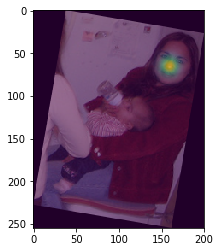

In [44]:
print(image.shape, target.shape)
img = np.transpose(image[0].cpu(), (1,2,0))
plt.imshow(img[:, :, [2,1,0]])
plt.imshow(target[0][0].cpu(), alpha = 0.5)
plt.show()

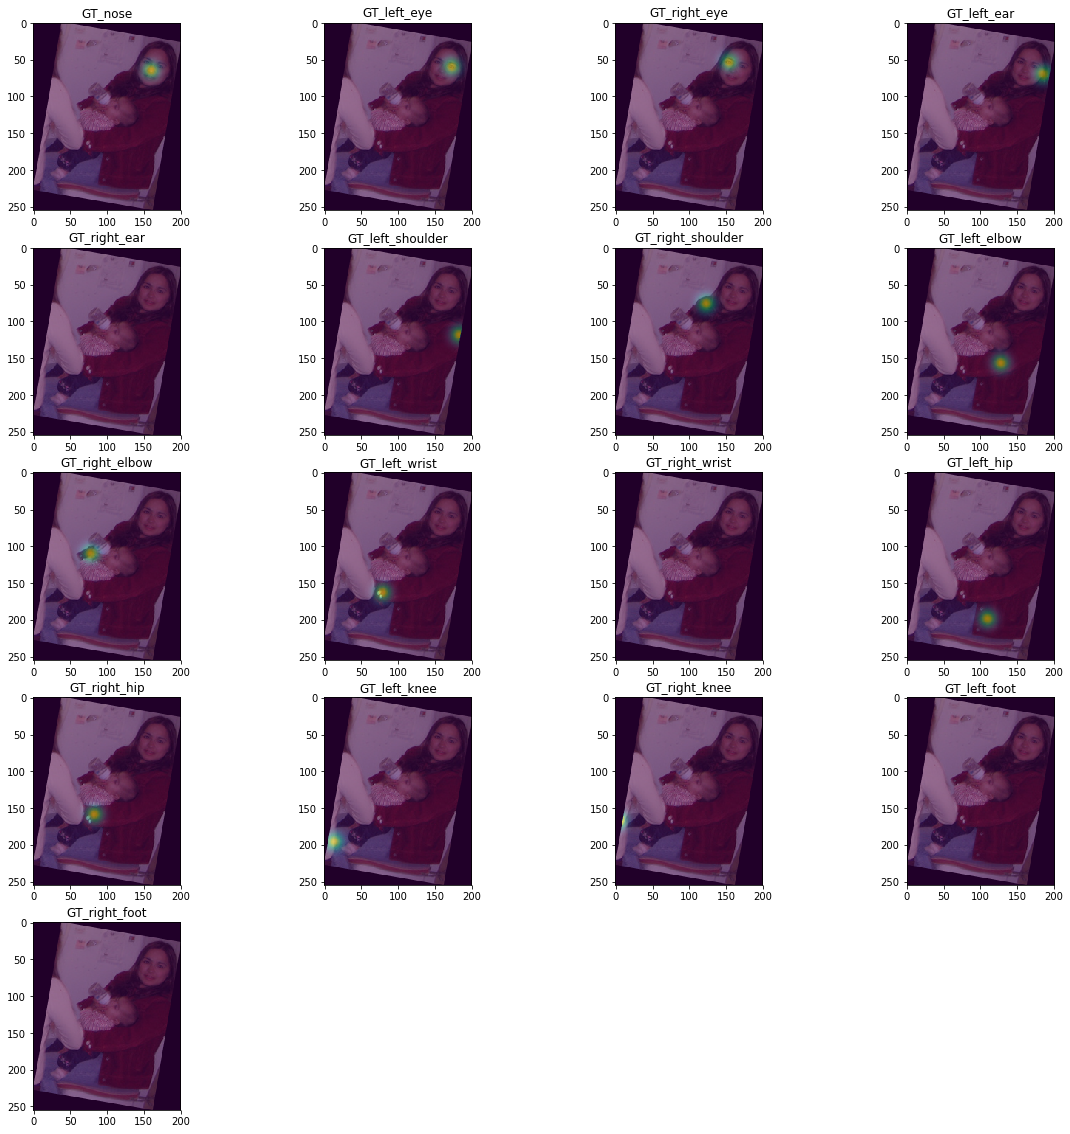

In [45]:
# visualizing ground truth heatmaps
fig = plt.figure(figsize = (20,20))
axes = []
for i in range(17):
    img = np.transpose(image[0].cpu(), (1,2,0))
    axes.append(fig.add_subplot(5, 4, i+1))
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.imshow(target[0][51+i].cpu(), alpha = 0.5)
    plt.title('GT_'+body_parts[i])
plt.show()

In [4]:
model = VRUNet().to('cuda')
model.load_state_dict(torch.load('trained_models/VRUNet_azure_19th_August_corrected.pth'))
model.eval()
print("pretrained model loaded")

pretrained model loaded


torch.Size([1, 68, 255, 200])


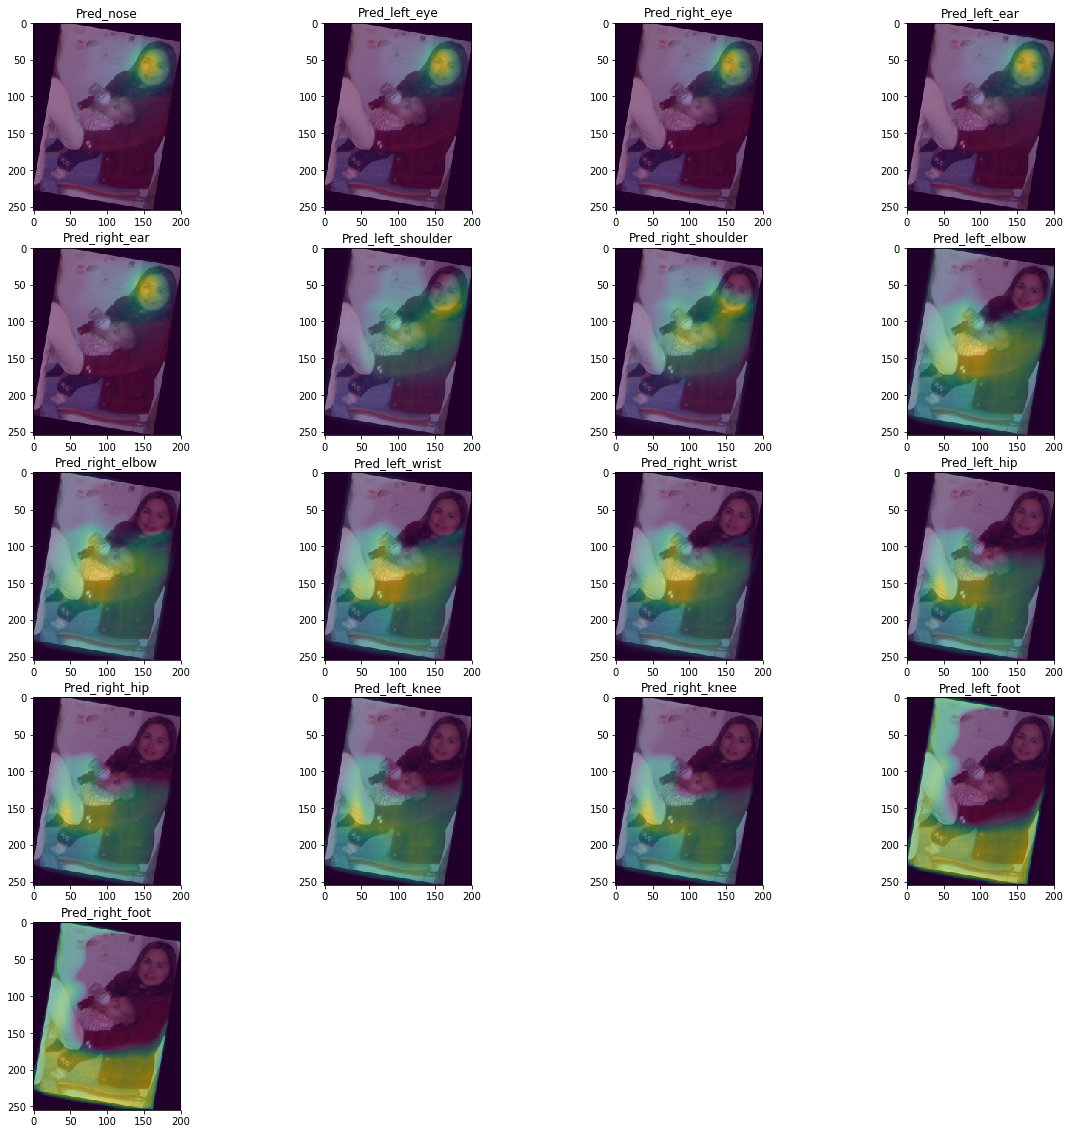

In [47]:
torch.cuda.empty_cache()
pred = model(image)
print(pred.shape)

# visualizing ground truth heatmaps
fig = plt.figure(figsize = (20,20))
axes = []
for i in range(17):
    img = np.transpose(image[0].cpu(), (1,2,0))
    axes.append(fig.add_subplot(5, 4, i+1))
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.imshow(pred[0][51+i].detach().cpu(), alpha = 0.5)
    plt.title('Pred_'+body_parts[i])
plt.show()

Input image shape : torch.Size([1, 3, 382, 576])


C:\Users\Kartikaeya\Anaconda3\lib\site-packages\torch\nn\functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


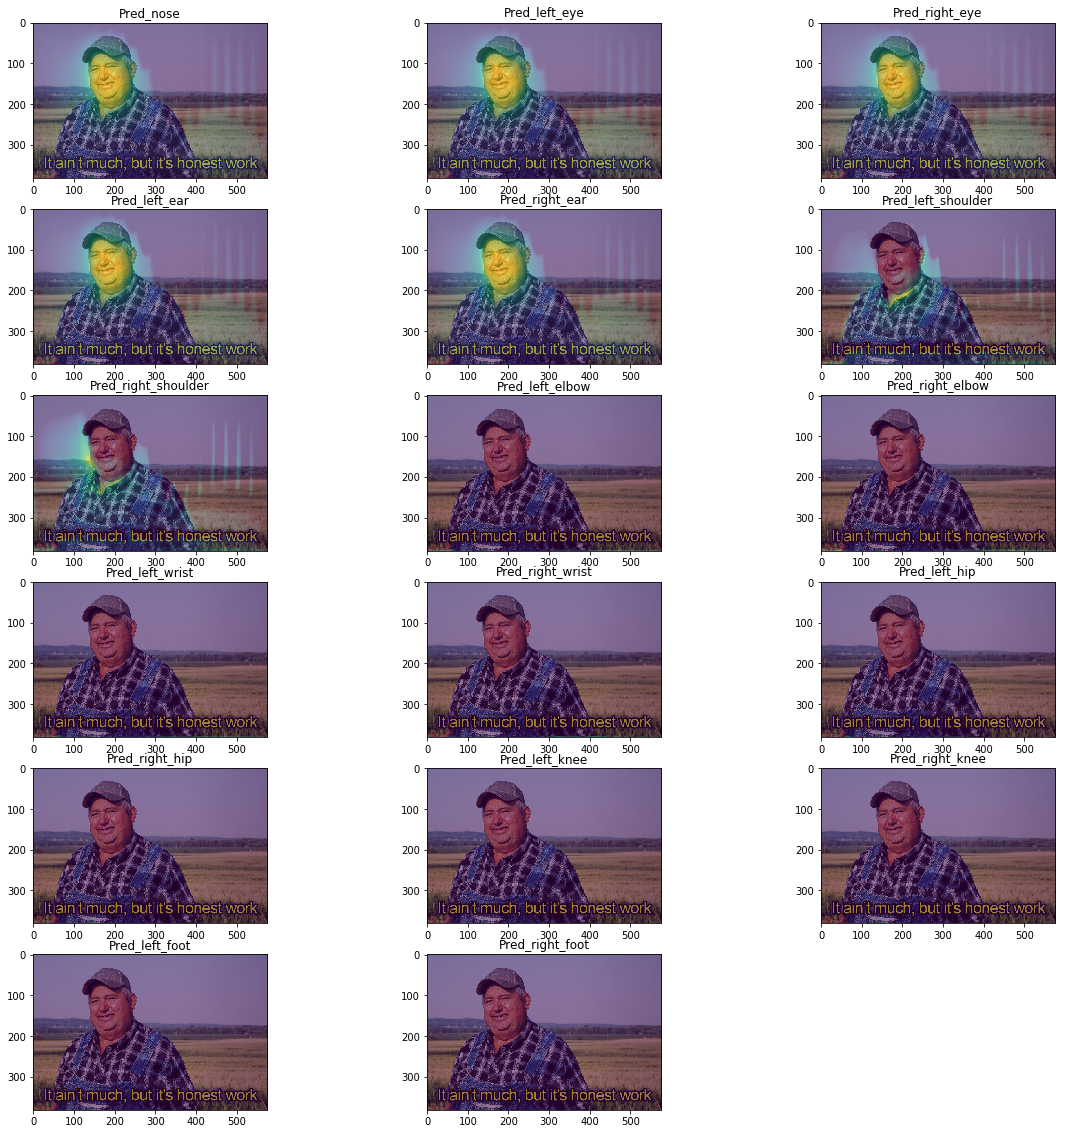

In [5]:
# if you want to run the model on any other image other than from the COCO dataset, run this block
torch.cuda.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

img = cv2.imread('C:/Users/Kartikaeya/Pictures/pose estimation pics/it_aint_much_meme.jpg')
image = cv2.resize(img, (0, 0), fx = 0.3, fy = 0.3)
img = np.transpose(image, (2, 0, 1))
img = torch.from_numpy(img)

mini_batch = torch.zeros((1, 3, img.shape[1], img.shape[2]), device = device)
mini_batch[0, :, :, :] = img


print("Input image shape :",mini_batch.shape)
pred = model(mini_batch)

# visualizing predicted heatmaps
fig = plt.figure(figsize = (20,20))
axes = []
for i in range(17):
    axes.append(fig.add_subplot(6, 3, i+1))
    plt.imshow(image[:, :, [2, 1, 0]])
    plt.imshow(pred[0][51+i].detach().cpu(), alpha = 0.5)
    plt.title('Pred_'+body_parts[i])
plt.show()